# This notebook plots lifecycle composites of MCS properties for a single tracker
## The MCS track statistics data is produced by:
* /src/make_mcs_stats_from_maskfile.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
xr.__version__

'2023.5.0'

In [3]:
# PHASE = 'Summer'
PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

lifetime_bounds = [2,80]
region = 'tropics'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input filenames
indir = f'{rootdir}/{tracker}/'
filenames = {key:f'{indir}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
# figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/SCREAM/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/


## Check if input files exist

In [4]:
for key, value in filenames.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_stats_Winter_GEOS.nc: 

## Show a map for the subset region

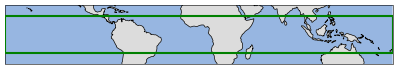

In [5]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [6]:
# Read a sample data
ds_tmp = xr.open_dataset(filenames['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [7]:
# xr.open_dataset(filenames_PyFLEXTRKR['obs']).isel({'times':slice(0,duration_max), 'nmaxpf':0})
# ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':})

In [8]:
# Read all files and combine them with a new dimension 'source'
ds = xr.open_mfdataset(list(filenames.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
ds['source'] = list(name_map.keys())
ds

<xarray.Dataset>
Dimensions:                  (tracks: 4941, times: 80, source: 13)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4937 4938 4939 4940
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm11' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4941), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4941), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4941), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 80), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Oct 27 14:09:44 2023

In [9]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-20, 15],
 [2, 80])

In [10]:
ds.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Fri Oct 27 14:09:44 2023'}

## Custom functions to subset tracks

In [11]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [12]:
dss = find_tracks_start(ds, load_data=False)

In [13]:
print(f'Number of MCS')
for key in dss['source'].data:
    ntracks = np.count_nonzero(dss.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS
OBS: 1758
OBSv7: 1944
ARPEGE: 1976
IFS: 2071
MPAS: 1325
SAM: 1893
UM: 1514
GRIST: 771
SCREAM: 1604
XSHiELD: 2376
GEOS: 1988
ICON: 2823
SCREAMv1: 2412


## Separate land vs. ocean MCS

In [14]:
dss_l, dss_o = get_land_ocean_ds(dss)

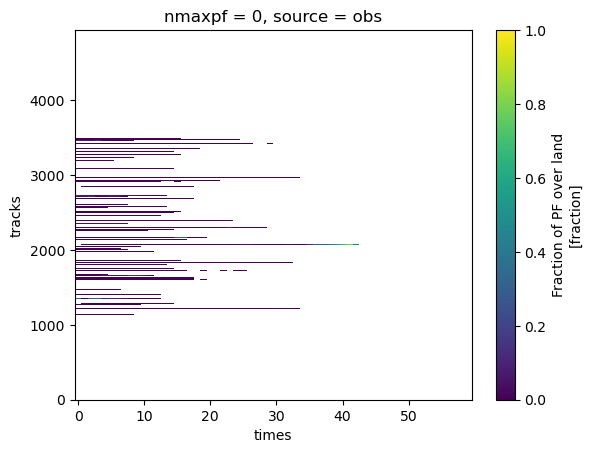

In [15]:
dss_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

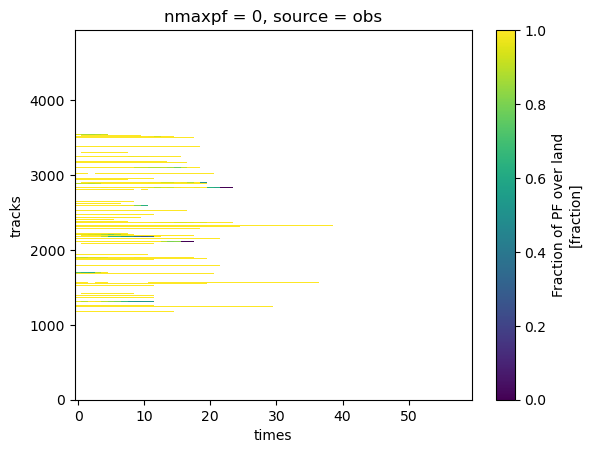

In [16]:
dss_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

## Use a simple method to separate possible merge/split tracks
### If max CCS area occur within the first x% of a tracks start time: split; or within last x% of a tracks end time: merge

In [17]:
# Set max area time fraction thresholds (if max area occur between these times, the track is retained)
# max_timefrac_thresh = [0.1, 0.9]
max_timefrac_thresh = [0.15, 0.85]

# # MCS lifetime range for composites
# lifetime_range1 = [10, 12]
# lifetime_range2 = [20, 24]

# MCS lifetime quantiles
quantiles = [0.25, 0.5, 0.75]
# Buffer for lifetime range [hour]
buffer = 1

In [18]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_o = dss_o.ccs_area.idxmax(dim='times', skipna=True) / dss_o.track_duration
maxccs_timefrac_l = dss_l.ccs_area.idxmax(dim='times', skipna=True) / dss_l.track_duration
# Do the same for PF area
maxpf_timefrac_o = dss_o.pf_area.idxmax(dim='times', skipna=True) / dss_o.track_duration
maxpf_timefrac_l = dss_l.pf_area.idxmax(dim='times', skipna=True) / dss_l.track_duration

# Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_o < max(max_timefrac_thresh)) & \
                        (maxpf_timefrac_o > min(max_timefrac_thresh)) & (maxpf_timefrac_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_l < max(max_timefrac_thresh)) & \
                        (maxpf_timefrac_l > min(max_timefrac_thresh)) & (maxpf_timefrac_l < max(max_timefrac_thresh))
# mask_nonmergesplit_o = (maxccs_timefrac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_l < max(max_timefrac_thresh))
                   
# CCS lifetime [hour]
ccslifetime_o = dss_o.track_duration * time_resolution
ccslifetime_l = dss_l.track_duration * time_resolution

# # Composite the DataSets by lifetime
# # Short-lived
# ds1_o = dss_o.where((mask_nonmergesplit_o) & (ccslifetime_o >= lifetime_range1[0]) & (ccslifetime_o <= lifetime_range1[1])).mean(dim='tracks')
# ds1_l = dss_l.where((mask_nonmergesplit_l) & (ccslifetime_l >= lifetime_range1[0]) & (ccslifetime_l <= lifetime_range1[1])).mean(dim='tracks')
# # Long-lived
# ds2_o = dss_o.where((mask_nonmergesplit_o) & (ccslifetime_o >= lifetime_range2[0]) & (ccslifetime_o <= lifetime_range2[1])).mean(dim='tracks')
# ds2_l = dss_l.where((mask_nonmergesplit_l) & (ccslifetime_l >= lifetime_range2[0]) & (ccslifetime_l <= lifetime_range2[1])).mean(dim='tracks')

# Get lifetime percentile values
lifetime_ranges_o = ccslifetime_o.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
lifetime_ranges_l = ccslifetime_l.chunk(dict(source=-1)).quantile(quantiles, skipna=True).load()
print(f'lifetime percentile values (ocean): {lifetime_ranges_l.data}')
print(f'lifetime percentile values (land): {lifetime_ranges_o.data}')

# Set a range around median lifetime
lifetime_range50_o = [lifetime_ranges_o.sel(quantile=0.5).item()-buffer,lifetime_ranges_o.sel(quantile=0.5).item()+buffer]
lifetime_range50_l = [lifetime_ranges_l.sel(quantile=0.5).item()-buffer,lifetime_ranges_l.sel(quantile=0.5).item()+buffer]
print(f'median lifetime range (ocean): {lifetime_range50_o}')
print(f'median lifetime range (land): {lifetime_range50_l}')

# Average DataSets for tracks with similar lifetime
ds50_o = dss_o.where((mask_nonmergesplit_o) & (ccslifetime_o >= min(lifetime_range50_o)) & (ccslifetime_o <= max(lifetime_range50_o))).mean(dim='tracks')
ds50_l = dss_l.where((mask_nonmergesplit_l) & (ccslifetime_l >= min(lifetime_range50_l)) & (ccslifetime_l <= max(lifetime_range50_l))).mean(dim='tracks')

lifetime percentile values (ocean): [10. 14. 19.]
lifetime percentile values (land): [10. 16. 24.]
median lifetime range (ocean): [15.0, 17.0]
median lifetime range (land): [13.0, 15.0]


(array([ 360.,  534.,  707., 1027.,  825., 1241., 1128.,  821.,  601.,
         548.]),
 array([0.15151515, 0.22121212, 0.29090909, 0.36060606, 0.43030303,
        0.5       , 0.56969697, 0.63939394, 0.70909091, 0.77878788,
        0.84848485]),
 <BarContainer object of 10 artists>)

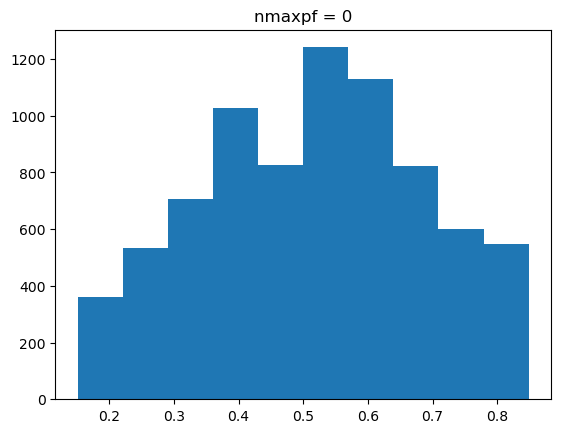

In [19]:
maxccs_timefrac_o.where(mask_nonmergesplit_o).plot.hist()

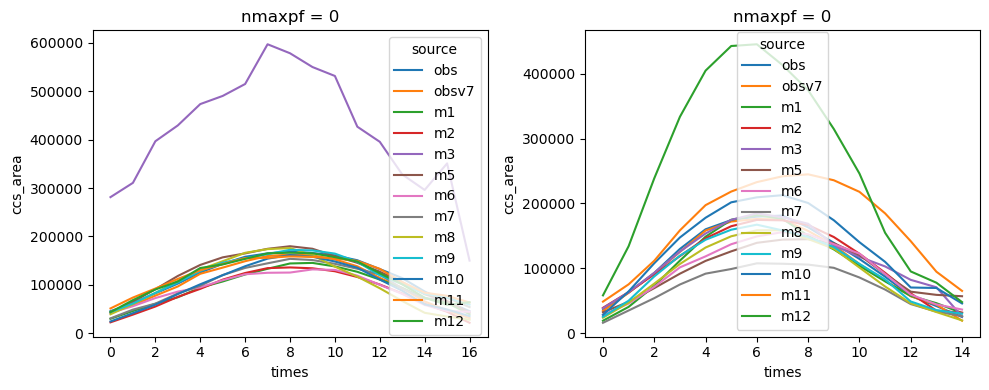

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
ds50_o.ccs_area.plot.line(x='times', ax=axes[0])
ds50_l.ccs_area.plot.line(x='times', ax=axes[1])
fig.tight_layout()

## Function to plot composite evolution

In [21]:
def plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, yticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, subtitle=None,
                 wspace=None, hspace=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs':'k', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for row in range(0, nrow):
        for col in range(0, ncol):
    
            ax = plt.subplot(gs[row,col], sharey=ax if col > 0 else None)
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.05, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Label x-axis for the last row
            if row == nrow-1:
                ax.set_xlabel(xlabels[col])
            else:
                ax.tick_params(axis='x', labelbottom=False)
            
            # Share y-axis for all columns in each row
            if col == 0:
                ax.set_ylabel(ylabels[row])
            else:
                ax.tick_params(axis='y', labelleft=False)
            # Hide the top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Plot data
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xtime, idata, lcolors[key], lw=lws[key], label=legends[key])
            # ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            if xticks is not None: ax.set_xticks(xticks)
            if ylims is not None: ax.set_ylim(ylims[col][0], ylims[col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            if titles is not None:
                flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
            # Draw an arrow to show the direction of time increase
            if (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))

    # Plot figure title
    # fig.suptitle(subtitle, y=1.03, fontsize=fontsize*2)
    
    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

### Put plotting variables in a list

In [22]:
pix_area = pixel_radius**2

# Data array [row][col]
data_arr_o = [
    [ds50_o.ccs_area.load(), ds50_l.ccs_area.load(),],
    [ds50_o.corecold_mintb.load(), ds50_l.corecold_mintb.load(), ],
    [ds50_o.pf_area.load(), ds50_l.pf_area.load(), ],
    [ds50_o.pf_rainrate.load(), ds50_l.pf_rainrate.load(), ],
    [ds50_o.total_rain.load()*pix_area, ds50_l.total_rain.load()*pix_area, ],
]
xtime = ds50_o.times.load()

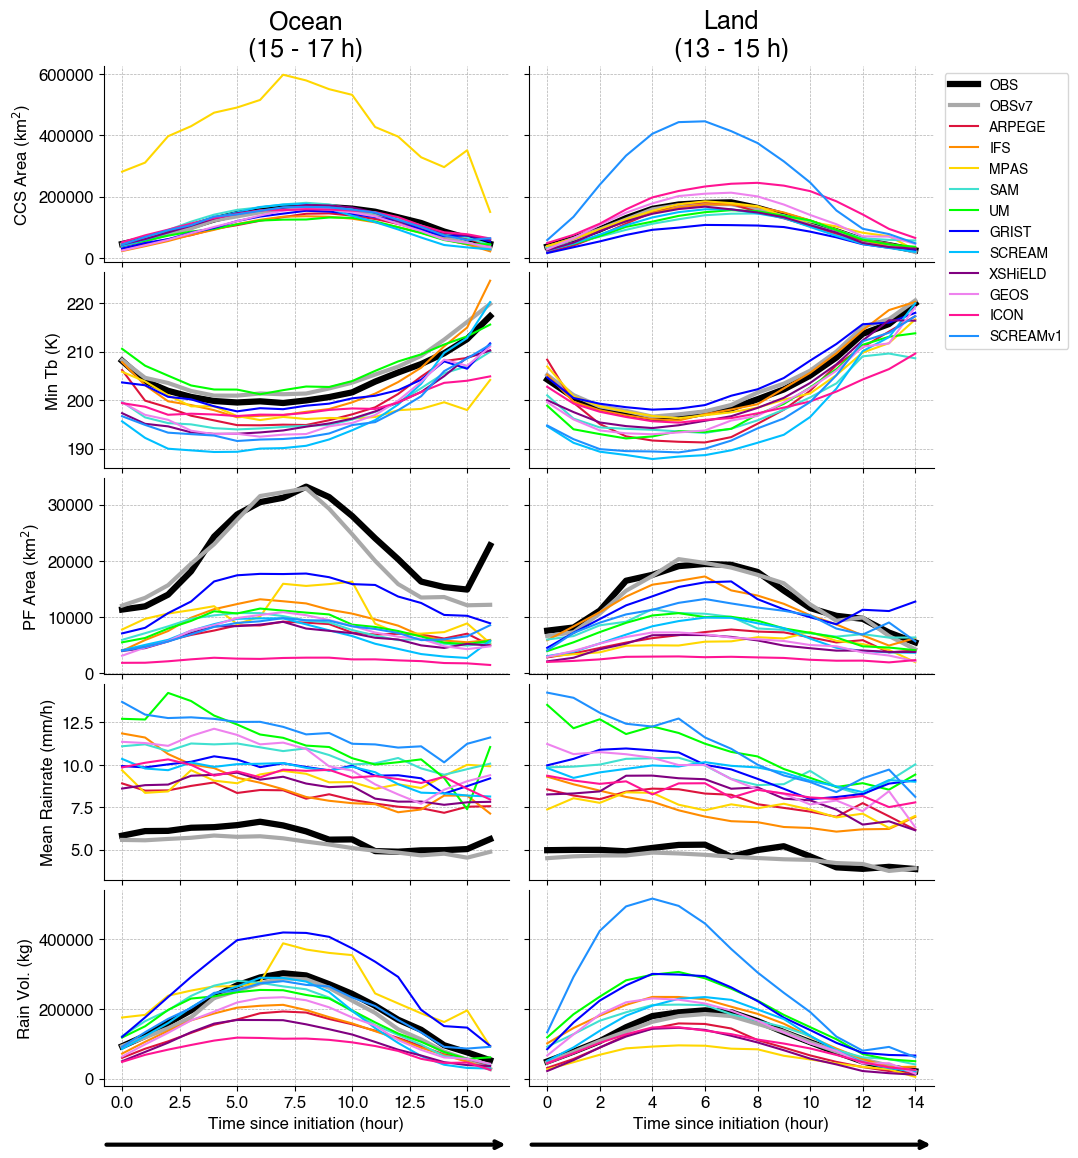

In [23]:
subtitle = tracker
legends = name_map
col_labels = [
    f'Ocean\n({lifetime_range50_o[0]:.0f} - {lifetime_range50_o[1]:.0f} h)',
    f'Land\n({lifetime_range50_l[0]:.0f} - {lifetime_range50_l[1]:.0f} h)',
]
nrow = len(data_arr_o)
ncol = len(col_labels)
titles = None
titles_loc = [0.97, 0.88]
title_ha = 'right'
xlabels = ['Time since initiation (hour)']*ncol
ylabels = ['CCS Area (km$^2$)', 'Min Tb (K)', 'PF Area (km$^2$)', 'Mean Rainrate (mm/h)', 'Rain Vol. (kg)']
# xlims = [(-25,40),(-25,40)]
xticks = None
xlims = None
# ylims = [(49,70),(43,60)]
# yticks = []
ylims = None
wspace = 0.05
hspace = 0.05
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.35, 1)
fontsize = 12
legend_fontsize = 10
figsize = [10,12]
figname = f'{figdir}mcs_composite_timeseries_ocean_land_{tracker}.png'

fig = plot_lines_mxn(nrow, ncol, data_arr_o, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels,
                   wspace=wspace, hspace=hspace, subtitle=subtitle, figname=figname, figsize=figsize)

In [24]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/mcs_composite_timeseries_ocean_land_PyFLEXTRKR.png'